<font size="5" id="authors"><b>Authors</b></font>
- Rom Gat (ID: 206395253)
- Shiran Naor (ID: 300212784)

<font size="4" id="prep"><b>Preparation</b></font>

In [ ]:
!pip install -q livelossplot
!git clone -q  https://github.com/rg-532/nlp_final_proj

In [ ]:
import os
import sys
import numpy as np
from functools import reduce
import pandas as pd

base_path = "/content/nlp_final_proj"
sys.path.append(base_path)
sys.path.append(base_path + "/resources")
corpus_path = os.path.join(os.getcwd(), base_path, "corpus")

from resources.utils import scrape_html, to_word_list
from resources.ner import extract_ner, ner_model_predictions
from resources.keywords import extract_keywords
from resources.sentiment import sentiment_tag, sentiment_model_predictions

<font size="6" id="intro"><b>Introduction</b></font>

The following notebook is a summary of the solutions for the various assignments included in the final project of the NLP course.

This notebook will be divided into the following sections:
- Named Entity Recognition (Tackling sections 2,6,7).
- Keyword Extraction (Tackling sections 3,4,10).
- Sentiment Analysis (Tackling section 8).
- Results and Statistics (Tackling sections 5,9)

It should be noted that the solution to section 1 is present in the 'scv_scrape.py' file.

Let's prepare the corpus by loading all files and formatting the texts into lists of words.

In [ ]:
raw_docs = {}
docs = {}

for filename in os.listdir(corpus_path):
    filepath = os.path.join(corpus_path, filename)
    raw_docs[filename] = [" ".join(s.split()) for s in scrape_html(filepath)]
    docs[filename] = to_word_list(" ".join(raw_docs[filename]))

<font size="6" id="ner"><b>Named Entity Recognition</b></font>

To recognize various named-entities in each document, we will make use of our knowledge of the structure of each file. We will start off by extracting the judges, prosecutors, defendants and the date from each document.

Simultaneously, we will also make sure to keep track of the sentences we parsed and the tags we assigned to them.

In [ ]:
docs_metadata, tagged_sents = extract_ner(raw_docs)

Now that that's done, we may attempt to train a model that can iterate over words and determine which type of NER it belongs to (with an additional non-NER type).

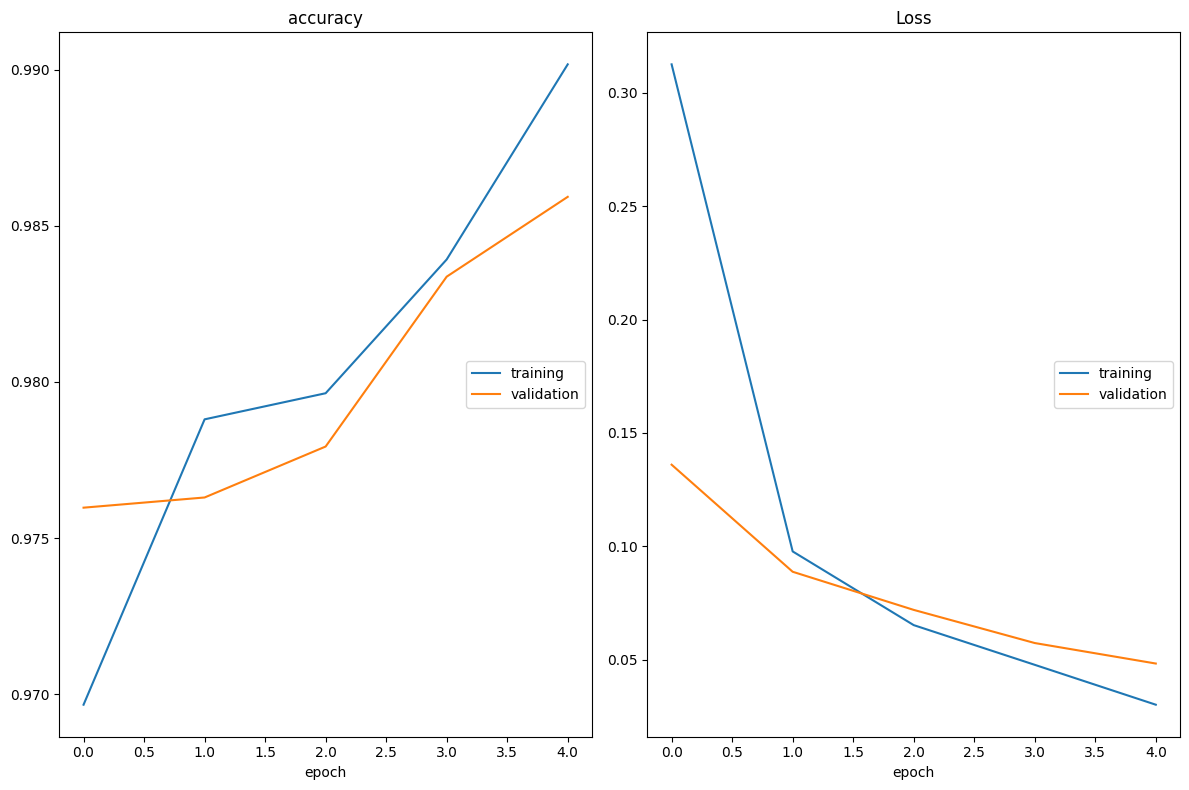

accuracy
	training         	 (min:    0.970, max:    0.990, cur:    0.990)
	validation       	 (min:    0.976, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.030, max:    0.313, cur:    0.030)
	validation       	 (min:    0.048, max:    0.136, cur:    0.048)
92/92 [==============================] - 39s 426ms/step - loss: 0.0301 - accuracy: 0.9902 - val_loss: 0.0483 - val_accuracy: 0.9859


Generating Predictions . . .: 3675it [05:18, 11.54it/s]


In [ ]:
ner_model_results = ner_model_predictions(tagged_sents)

Let's compare the results of these two NER extracting methods. Since the rule-based technique set the tags for each word when training, the resulted **accuracy** does demonstrate how well our model did at extracting the NERs.

Let's also show the tag and prediction for each word in the entire corpus.

In [ ]:
ner_results = {"Word": [], "Tag": [], "Prediction": []}

for ner_batch in ner_model_results:
    for ner_sample in ner_batch:
        ner_results["Word"].append(ner_sample[0])
        ner_results["Tag"].append(ner_sample[1])
        ner_results["Prediction"].append(ner_sample[2])

ner_results_df = pd.DataFrame(ner_results)

ner_results_df.to_excel("/content/NER_Results.xlsx", index=False)
display(ner_results_df)

,Word,Tag,Prediction
0,"ההסגרה,",O,O
1,אין,O,O
2,בה,O,O
3,משום,O,O
4,נסיבה,O,O
...,...,...,...
183745,אחד,O,O
183746,עם,O,O
183747,עקרון,O,O
183748,טובת,O,O


<font size="6" id="keywords"><b>Keyword Extraction</b></font>

To extract relevant keywords from documents, we will attempt to **score** each word separately for each document, such that a higher score is indicative of a better likelihood of the word serving as a keyword for the document.

We will make use of 3 methods for scoring words in documents:
- **TF-IDF** - We will calculate the TF-IDF score for each word in each document. This will be our baseline keyword extraction method, and the other two will be compared to this.

- **WORD2VEC** - We will use WORD2VEC to generate embeddings for each word. Then, we will calculate embeddings for each document by averaging the word embeddings within each document. Finally, we will use the Gaussian Similarity Function to measure proximity between each word and each document, and use that as the score.

- **Recurrent Autoencoder** - We will construct a recurrent autoencoder network to calculate embeddings for each word. Then we will proceed as we did in the previous method.

In [ ]:
tf_idf_keywords = extract_keywords(docs, "tf-idf")

In [ ]:
w2v_keywords = extract_keywords(docs, "word2vec")

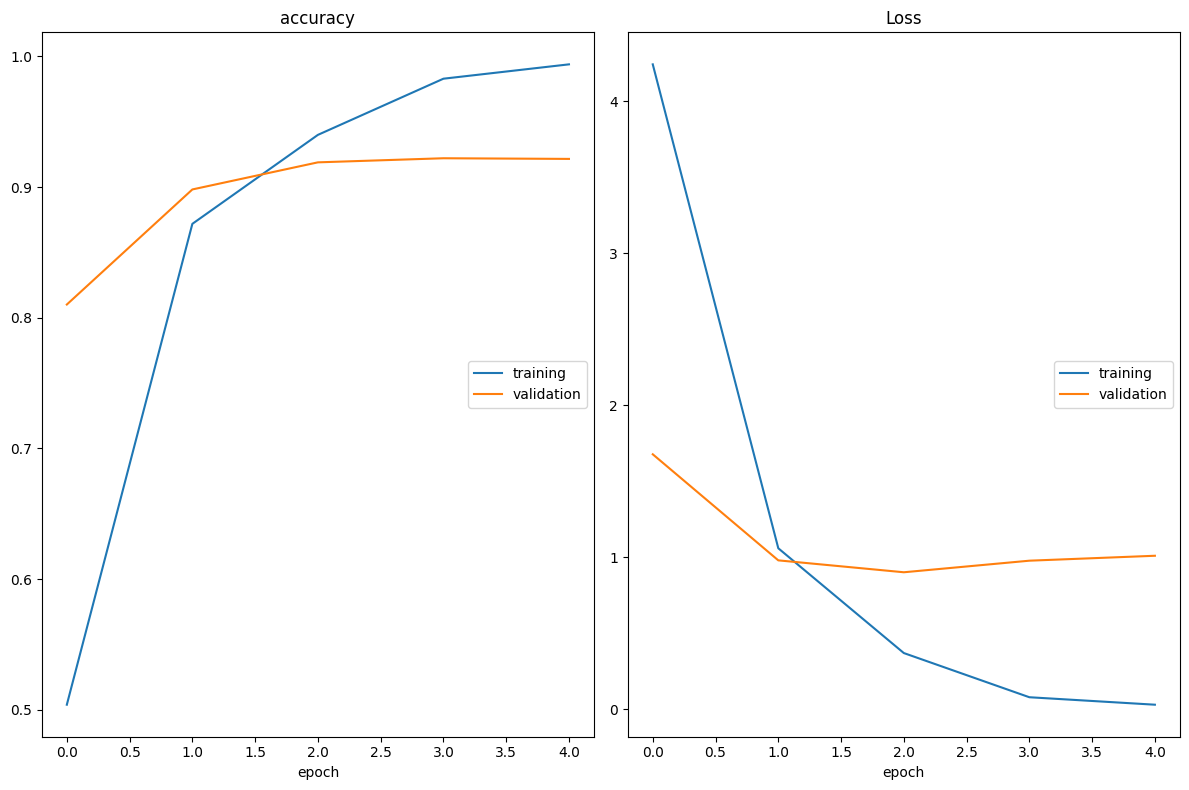

accuracy
	training         	 (min:    0.504, max:    0.994, cur:    0.994)
	validation       	 (min:    0.810, max:    0.922, cur:    0.922)
Loss
	training         	 (min:    0.029, max:    4.245, cur:    0.029)
	validation       	 (min:    0.901, max:    1.677, cur:    1.009)
302/302 [==============================] - 42s 141ms/step - loss: 0.0285 - accuracy: 0.9939 - val_loss: 1.0092 - val_accuracy: 0.9215


Generating Embeddings . . .: 100%|██████████| 377/377 [00:54<00:00,  6.89it/s]


In [ ]:
ae_keywords = extract_keywords(docs, "autoencoder")

Let's view the keywords extracted by each method.

In [ ]:
docs_metadata["Keywords"] = []
keyword_extraction_results = {
    "Document": [],
    "TF-IDF Keywords": [],
    "WORD2VEC Keywords": [],
    "Autoencoder Keywords": []
}

for dname in docs_metadata["Document"]:
    docs_metadata["Keywords"].append(list(tf_idf_keywords[dname].keys()))
    keyword_extraction_results["Document"].append(dname)

    for key, val in zip(
        ["TF-IDF Keywords", "WORD2VEC Keywords", "Autoencoder Keywords"],
        [tf_idf_keywords, w2v_keywords, ae_keywords]
    ):
        keyword_extraction_results[key].append(list(val[dname].keys()))

keyword_extraction_results_df = pd.DataFrame(keyword_extraction_results)

keyword_extraction_results_df.to_excel("/content/Keyword_Extraction_Results.xlsx", index=False)
display(keyword_extraction_results_df)

,Document,TF-IDF Keywords,WORD2VEC Keywords,Autoencoder Keywords
0,21035430.E09.html,"[פיליפ, צימברג, השופת, כ""ח, קלנר]","[אליהו, ‏ט""ז, תמיר, מיכאל, עופר]","[ישקף, ב""סְפֵירָה, לאשפזה, מקבילים, ועקרון]"
1,23037940.N04.html,"[נשק, גוואד, אלקיעאן, גביזון, להובלת]","[‏י""ח, כ""ד, ‏כ""ד, לנוער, ‏כ""ט]","[ל-14, חשובות, בחו""ל, התש""פ-2019, כחתום]"
2,23046600.E01.html,"[השלום, ההוכחות, התיקים, ההליכים, העותר]","[קול, כבערעור, להבנתי, גרוזובסקי, עכו]","[הוספה, מוזס, להטלת, הבלעדית, והגנים]"
3,23040860.M03.html,"[רעול, בעצרות, חמושות, מיוחס, באוויר]","[‏ט""ז, עבדאללה, אסמאעיל, חאלד, מחמד]","[תום-ליבם, יגדרו, למערערים, מהאשפוז, להסדר]"
4,21080470.O06.html,"[י.ח, ולנסי, הארי, בע""מ, ח.י]","[אליהו, תמיר, ויצמן, ‏ט""ז, נצרת]","[פירושה, בהמשך, השאלות, בפעם, אינם]"
...,...,...,...,...
495,22016970.O20.html,"[הרבני, צדיקה, פסיכו-דיאגנוסטי, האזורי, האבחון]","[אליהו, ‏ט""ז, ‏כ""ג, ריאטי, מתניה]","[שמכוחם, נייד, למשל, האוחז, לודא]"
496,23037670.E03.html,"[העותר, הצו, בקבוקי, תבערה, הצבאי]","[לעיוננו, ונחה, חסוי, חיוניות, בבקשתו]","[משתי, הונפק, שרת, שנים, מערעורו]"
497,23020940.M09.html,"[מלאכי, בקריית, אכלוס, הדירה, בבאר]","[כ""ד, ‏י""ח, ‏ט""ז, פקדון, נתנאל]","[ברשתות, הסתפקות, חוק, המאזניים, וסחר]"
498,22086700.M02.html,"[איסמעיל, בטרור, המאבק, הענישה, עבירה]","[מעבירת, מרבע, איסמעיל, 15(ד1)(2, המלמדות]","[להישנות, מרגלית, החסויים, במכרז, שיוקם]"


It seems that the TF-IDF keywords mainly represent main subjects in each verdict. The WORD2VEC keywords are completely different and for the most part they capture numbers (in hebrew letters) and names. The autoencoder keywords are also different from the last two and don't seem to tend to capture anything specific.

We think that this difference is the result of a misuse of generated word embeddings in identifying keywords - It may not be that proximity among words is indicative of a word being a keyword, and perhaps there is a different approach for finding keywords (Such as proper document embeddings which are close to their keywords).

<font size="6" id="sentiment"><b>Sentiment Analysis</b></font>

Before attempting to predict the sentiment for each document, we will first define what we choose to refer to as sentiment in the case of a verdict:
- If the request made in the document was approved, then the verdict has a positive sentiment.
- If the request made in the document was denied, then the verdict has a negative sentiment.
- Otherwise, the verdict has a neutral sentiment.

We will first make use of a rule-based approach for tagging documents. This approach will count the number of positive words (indicating acceptance) and negative words (indicating denial) and set the sentiment to be the one with most indicative words. If these to amounts are equal (most commonly, we get 0 for both amounts in this case), then we will set the sentiment to be neutral.

In [ ]:
sentiment_tags = sentiment_tag(raw_docs)

Now we are ready to create and train a recurrent network which predicts sentiment from a document.

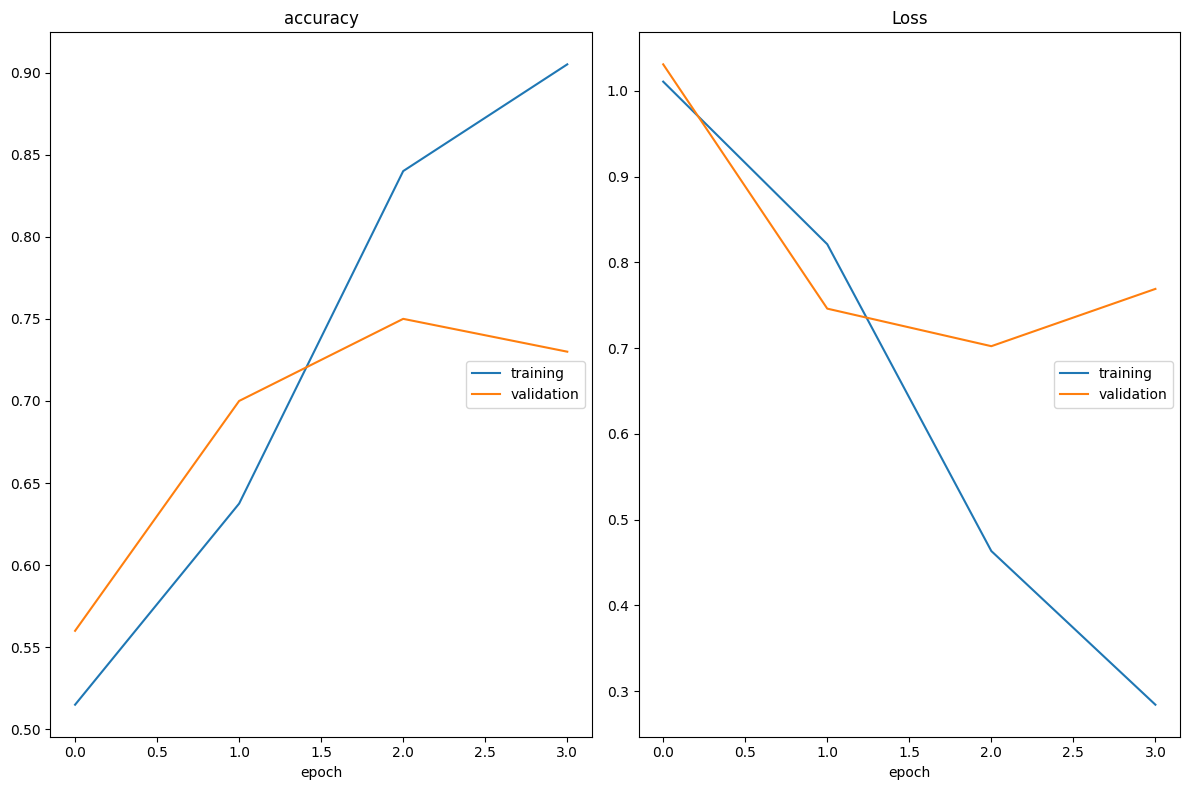

accuracy
	training         	 (min:    0.515, max:    0.905, cur:    0.905)
	validation       	 (min:    0.560, max:    0.750, cur:    0.730)
Loss
	training         	 (min:    0.284, max:    1.011, cur:    0.284)
	validation       	 (min:    0.702, max:    1.031, cur:    0.769)
400/400 [==============================] - 274s 684ms/step - loss: 0.2840 - accuracy: 0.9050 - val_loss: 0.7691 - val_accuracy: 0.7300


Generating Predictions . . .: 500it [02:31,  3.30it/s]


In [ ]:
sentiment_model_results = sentiment_model_predictions(docs, sentiment_tags)

Finally, we may compare the results of the model and the rule-based tagging.

In [ ]:
docs_metadata["Sentiment"] = []
sentiment_results = {"Document": [], "Sentiment": [], "Prediction": []}

for dname in docs_metadata["Document"]:
    docs_metadata["Sentiment"].append(sentiment_tags[dname])

    sentiment_results["Document"].append(dname)
    sentiment_results["Sentiment"].append(sentiment_tags[dname])
    sentiment_results["Prediction"].append(sentiment_model_results[dname])

sentiment_results_df = pd.DataFrame(sentiment_results)

sentiment_results_df.to_excel("/content/Sentiment_Results.xlsx", index=False)
display(sentiment_results_df)

,Document,Sentiment,Prediction
0,21035430.E09.html,NEGATIVE,NEGATIVE
1,23037940.N04.html,NEUTRAL,NEUTRAL
2,23046600.E01.html,NEGATIVE,POSITIVE
3,23040860.M03.html,NEGATIVE,NEGATIVE
4,21080470.O06.html,NEGATIVE,NEGATIVE
...,...,...,...
495,22016970.O20.html,NEGATIVE,NEGATIVE
496,23037670.E03.html,NEGATIVE,NEGATIVE
497,23020940.M09.html,NEUTRAL,NEUTRAL
498,22086700.M02.html,NEGATIVE,NEGATIVE


As we can see by the accuracy at the end of training,  there is still much to improve here, both in tagging and in modeling. We did manage to get pretty decent results, however, and from the table above we can see many correct predictions of negative and neutral sentiments. It seems that our model fails to predict positive samples, probably because there are many less of those.

<font size="6" id="summary"><b>Results and Statistics</b></font>

Let's begin by showing the resulted dataframe which includes all of the collected metadata on the documents in the corpus. This contains the NER rule-based results, the TF-IDF keywords and the rule-based sentiments of each document.

In [ ]:
docs_metadata_df = pd.DataFrame(docs_metadata)

docs_metadata_df.to_excel("/content/Documents_Metadata.xlsx", index=False)
display(docs_metadata_df)

,Document,Judges,Prosecutors,Defendants,Date,Keywords,Sentiment
0,21035430.E09.html,"[כבוד השופט י' עמית, כבוד השופטת ע' ברון, כבוד...",[פיליפ יאיר צלח],"[ בנק הפועלים בע""מ, דב צימברג, סופר מודיעין ...",19.4.2023,"[פיליפ, צימברג, השופת, כ""ח, קלנר]",NEGATIVE
1,23037940.N04.html,"[כבוד המשנה לנשיאה ע' פוגלמן, כבוד השופט ד' מי...",[גוואד אבו אלקיעאן],[מדינת ישראל],11.6.2023,"[נשק, גוואד, אלקיעאן, גביזון, להובלת]",NEUTRAL
2,23046600.E01.html,"[כבוד השופט י' עמית, כבוד השופטת ד' ברק-ארז, כ...",[דוד שלתיאל],[בית המשפט השלום באר שבע],2.7.2023,"[השלום, ההוכחות, התיקים, ההליכים, העותר]",NEGATIVE
3,23040860.M03.html,"[כבוד המשנה לנשיאה ע' פוגלמן, כבוד השופט ד' מי...",[יוסף תאופיק מוחמד עיסא],"[ מפקד כוחות צה""ל באיו""ש, שופט בית המשפט הצבא...",5.7.2023,"[רעול, בעצרות, חמושות, מיוחס, באוויר]",NEGATIVE
4,21080470.O06.html,"[כבוד השופט נ' סולברג, כבוד השופט ע' גרוסקופף,...","[ ג'אן מרק ויקטור ולנסי, חי ולנסי בע""מ, אינש...","[ יצחק תשובה, יצחק תשובה אחזקות בע""מ, יח האר...",5.7.2023,"[י.ח, ולנסי, הארי, בע""מ, ח.י]",NEGATIVE
...,...,...,...,...,...,...,...
495,22016970.O20.html,"[כבוד השופט נ' סולברג, כבוד השופט א' שטיין, כב...",[פלוני],"[ בית הדין הרבני הגדול לערעורים, בית הדין הרב...",14.6.2023,"[הרבני, צדיקה, פסיכו-דיאגנוסטי, האזורי, האבחון]",NEGATIVE
496,23037670.E03.html,"[כבוד השופט י' עמית, כבוד השופט ד' מינץ, כבוד ...",[מחמד שפיק מראר],"[ שופט צבאי משפטאי, המפקד הצבאי איו""ש, שירות...",1.6.2023,"[העותר, הצו, בקבוקי, תבערה, הצבאי]",NEGATIVE
497,23020940.M09.html,"[כבוד המשנה לנשיאה ע' פוגלמן, כבוד השופט נ' סו...",[דניאל סהלו],"[ עמידר – החברה הלאומית לשיכון בישראל, משרד ה...",10.7.2023,"[מלאכי, בקריית, אכלוס, הדירה, בבאר]",NEUTRAL
498,22086700.M02.html,"[כבוד המשנה לנשיאה ע' פוגלמן, כבוד השופטת ד' ב...",[אחמד אבו נאמוס],[מדינת ישראל],21.6.2023,"[איסמעיל, בטרור, המאבק, הענישה, עבירה]",NEGATIVE


We will use the created metadata to find:
- How many verdicts were given by each judge.
- How many verdicts with a certain keyword out of the top 10 keywords there are.
- How many verdicts of a certain sentiment were given by each judge.
- How many verdicts of a certain sentiment there are.

In [ ]:
judges = list(set(reduce(lambda x,y: x+y, docs_metadata["Judges"])))

keyword_freqs = {}
verdicts_by_judge = {j: 0 for j in judges}
sentiment_by_judge = {j: {"POSITIVE": 0, "NEGATIVE": 0, "NEUTRAL": 0} for j in judges}
sentiment_counts = {"POSITIVE": 0, "NEGATIVE": 0, "NEUTRAL": 0}

for i in range(len(docs_metadata["Document"])):
    for judge in docs_metadata["Judges"][i]:
        verdicts_by_judge[judge] += 1
        sentiment_by_judge[judge][docs_metadata["Sentiment"][i]] += 1

    for kw in docs_metadata["Keywords"][i]:
        keyword_freqs[kw] = keyword_freqs.get(kw, 0) + 1

    sentiment_counts[docs_metadata["Sentiment"][i]] += 1

keyword_freqs = sorted(keyword_freqs.items(), key=lambda x: x[1], reverse=True)
keyword_freqs = {kw[0]: kw[1] for kw in keyword_freqs[:10]}

In [ ]:
pd.DataFrame.from_dict(verdicts_by_judge, orient="index", columns=["Verdicts"])

,Verdicts
כבוד השופט י' כשר,108
כבוד השופט ד' ברק-ארז,1
כבוד הרשמת קרן אזולאי,8
כבוד השופט ע' גרוסקופף,96
כבוד השופט ש' שוחט,2
כבוד השופטת ע' ברון,18
כבוד השופט נ' סולברג,88
כבוד הרשמת ליאור משאלי שלומאי,7
כבוד המשנה לנשיאה ע' פוגלמן,74
כבוד השופט ח' כבוב,111


In [ ]:
pd.DataFrame.from_dict(keyword_freqs, orient="index", columns=["Verdicts"])

,Verdicts
העותר,56
המערער,40
המערערים,26
העותרת,23
העותרים,21
המערערת,21
הצו,15
הצבאי,15
"בע""פ",12
לנשיאה,11


In [ ]:
pd.DataFrame.from_dict(sentiment_by_judge, orient="index")

,POSITIVE,NEGATIVE,NEUTRAL
כבוד השופט י' כשר,15,59,34
כבוד השופט ד' ברק-ארז,0,1,0
כבוד הרשמת קרן אזולאי,0,0,8
כבוד השופט ע' גרוסקופף,16,45,35
כבוד השופט ש' שוחט,2,0,0
כבוד השופטת ע' ברון,6,7,5
כבוד השופט נ' סולברג,6,53,29
כבוד הרשמת ליאור משאלי שלומאי,1,0,6
כבוד המשנה לנשיאה ע' פוגלמן,4,40,30
כבוד השופט ח' כבוב,11,59,41


In [ ]:
pd.DataFrame.from_dict(sentiment_counts, orient="index", columns=["Verdicts"])

,Verdicts
POSITIVE,69
NEGATIVE,262
NEUTRAL,169
